# Group Invariant Convolutional Network
Invariance is one of the most important concepts in deep learning. A classification function indeed, should be invariant to all that transformations that leave the object unchanged. One of the most used technique to achieve invariance is called "data augmentation", and it consists in adding transformed samples to the training set. In this project we show how invariance can be obtained exploiting the equivariance property of the convolution operation without relying on data augmentation.

In this project we will detail the implementation of the group equivariant convolution, introduced in (Cohen & Welling, 2016),for the Dihedral Group D4, that is the group of symmetries of a square. The actions of the group are the four $90^\circ$ rotations and reflections along the four axis of symmetry, that are the two perpendicular lines passing through midpoints of opposite sides and the two perpendicular lines passing through opposite vertices.
Then we use the D4 equivariant convolution to get a representation that is invariant to the group actions through Max Pooling.

## Dihedral Group D4
In this section I will explain the class `DihedralGroup`, that implement the effect of the actions of the group on the R2 grid and on other group actions.

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from groupconv.groups import *
from groupconv.conv import *
from models.baseline import SimpleCNN
from models.equivariant import EqSimpleCNN
from utils.train import val,count_params
from data.loader import get_loader
import matplotlib.pyplot as plt
import itertools
torch.manual_seed(0)

The class `DihedralGroup` implements the actions of the DihedralGroup, that is the symmetry group of rotations and reflections of a regular polygon with n vertices. For this reason the constructor needs the number of vertices of the polygon. In the network implementation we will restrict to the d4 group (symmetries of a square) in order to not introduce interpolation artifacts. However we implemented the DihedralGroup parametric in the number of vertices, so that the group can be instantiated for any regular polygon, and if the coordinates of the transformed grid do not end up into integer coordinates the resulting pixel is interpolated.

In [2]:
d4 = DihedralGroup(4)
rot0, rot1, rot2, rot3, ref1, ref2, ref3, ref4 = d4.elements()

/home/giorgio/Desktop/GroupEquivariantConvNetworks/DLAI_D4EqConvNet/groupconv/groups.py:203: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  return torch.range(start=0,end=self.order-1,dtype=torch.int32)


In [3]:
img = Image.open("images/bitmap.png").convert('RGB')
img_tensor = transforms.ToTensor()(img)
img_tensor.shape

torch.Size([3, 547, 547])

In [4]:
# This creates a grid of the pixel locations in our image, normalized in the range [-1,1]
img_grid_R2 = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    torch.linspace(-1, 1, img_tensor.shape[-2]),
))
img_grid_R2.shape

/home/giorgio/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([2, 547, 547])

The method `left_action_on_R2` takes a batch of group actions and a 2D grid and apply each action to the grid.

In [5]:
actions = torch.stack([rot0, rot1, rot2, rot3, ref1, ref2, ref3, ref4],dim=0)
transformed_grid = d4.left_action_on_R2(d4.inverse(actions),img_grid_R2)
transformed_grid.shape

torch.Size([8, 547, 547, 2])

In [6]:
# Given an input and a grid, computes the output using input values and pixel locations from grid.
# Grid and input are expected to have same batch size, hence we repeat the img_tensor for each action
# along the first axis.
img_tensor = img_tensor.unsqueeze(0).repeat(8,1,1,1)
transformed_imgs = torch.nn.functional.grid_sample(img_tensor,transformed_grid,align_corners=True, mode="bilinear")
transformed_imgs.shape

torch.Size([8, 3, 547, 547])

The following figure shows the effects of all the 8 actions on an image. In the first row we see all the rotations, and in particular from left to right:
- 0 degrees (identity)
- 90 degrees counterclockwise
- 180 degrees counterclockwise
- 270 degrees counterclockwise

While on the second row the effects of the reflections are shown. From left to right:
- reflection along vertical axis
- reflection along first diagonal
- reflection along horizontal axis
- reflection along second diagonal

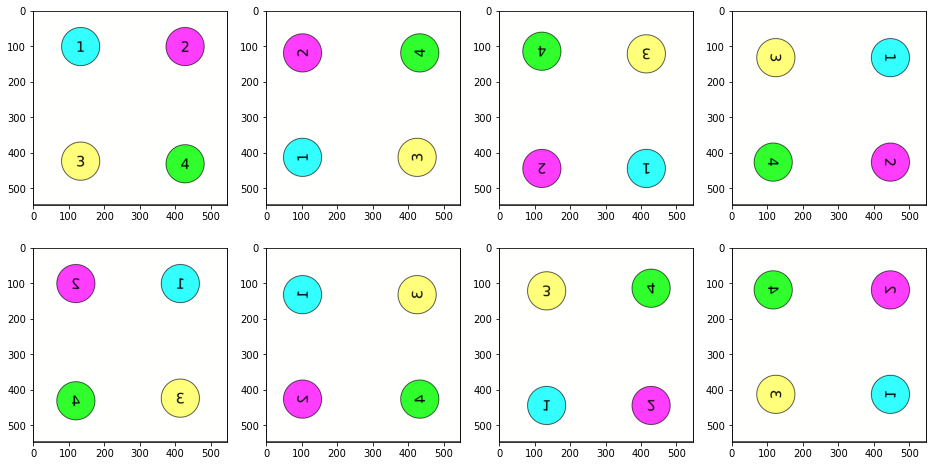

In [7]:
transformed_imgs_chlast = torch.einsum("bchw->bhwc",transformed_imgs)
fig,axes = plt.subplots(2,4)
fig.set_size_inches(16,8)
for i,ax in enumerate(axes.flat):
    ax.imshow(transformed_imgs_chlast[i])
plt.show()


## Group Equivariant Convolution
In this section we will discuss the Group Equivariant Convolution and its implementation.

### From Standard Convolution to Group Equivariant Convolution
Before delving into the implementation details of the group equivariant convolution, let us recall the equation of the standard convolution:
$$
[f * \psi](x) = \sum_{y\in Z^2}\sum_{k=1}^{K^l}f_k(y)\psi_{k}^i(x-y)
$$
Where $f:Z^2 \rightarrow R^{K^l}$ is the input feature map and $\psi^i : Z^2 \rightarrow R^{K^l}$ is the filter.
In order to generalize the convolution to a broader symmetry group (that includes translation) we need to introduce the following notation:
$$
[L_g f](x) = [f \circ g^{-1}](x) = f(g^{-1}x)
$$
that is better explained through an example. Let us consider an image $f(x)$ as a function of the 2D grid $x$. If we want to rotate the image of $90^{\circ}$ counterclockwise ($[L_g f](x)$ where g is the counterclockwise rotation of $90^{\circ}$) we need to rotate the grid clockwise (applying the inverse transform $g^{-1}x$) and then use the transformed grid to lookup in the original image $f(g^{-1}x)$.
In the group equivariant convolution we replace the shift with a more general discrete group G.
However we need to distinguish two cases. In first convolutional layer, the input $f(x)$ and the filter $\psi$ are both functions of $Z^2$. In other words, they are defined over the 2D grid. The output feature map instead is a function on G, the equation is:
$$
[f * \psi^i](g) = \sum_{y\in Z^2}\sum_k f_k(y)\psi_{k}^i(g^{-1}y)
$$
In the further convolutions, both the input and the filters are functions of G:
$$
[f * \psi^i](g) = \sum_{h\in G}\sum_k f_k(h)\psi_{k}^i(g^{-1}h)
$$
In order to leverage the pytorch implementation of the planar convolution we will consider a group that is a split, meaning that every action $g$ can be decomposed into a translation $t$ and another action $s$ that leaves the origin unchanged, hence $g=ts$. In this case the convolution can be written as:
$$
   [f * \psi^i](ts) = \sum_{h\in X}\sum_k f_k(h)L_t[L_s\psi_{k}^i(h)]
$$
Where $X=Z^2$ in the the first convolution and $X=G$ in further convolutions. Let us call $H$ the stabilizer, that is the subgroup of all actions that leave the origin unchanged (that in our case is the D4 group). 
In the last equation we first transform the filter $\psi$ with the action s and then apply the translation. 


#### Lifting Convolution
In the first convolutional layer, called "lifting convolution", the input has shape `(in channels, spatial dim 1, spatial dim 2)` and the kernel has shape `(in channels, out channels, spatial dim 1, spatial dim 2)` while the output is a function of the group and hence it has an additional dimension. Its shape is `(out channels, elements of H, spatial dim 1, spatial dim 2)`. In order to use the standard planar convolution algorithm, each filter is transformed with every action of H and the additional dimension is joined with the `out channels` dimension. 

In [8]:
kernel_weights = Image.open("images/bitmap.png").convert('L')
kernel_weights = transforms.ToTensor()(kernel_weights)[0,...]
kernel_weights.shape

torch.Size([547, 547])

In [9]:
lift_conv = LiftingConvolution(group=d4,in_channels=1,out_channels=1,kernel_size=547)
lift_conv.kernel.weight.data = kernel_weights.unsqueeze(0).unsqueeze(0)
lift_conv.kernel.weight.data.shape

torch.Size([1, 1, 547, 547])

In [10]:
kernels = lift_conv.kernel.sample().detach()
kernels.shape

torch.Size([1, 8, 1, 547, 547])

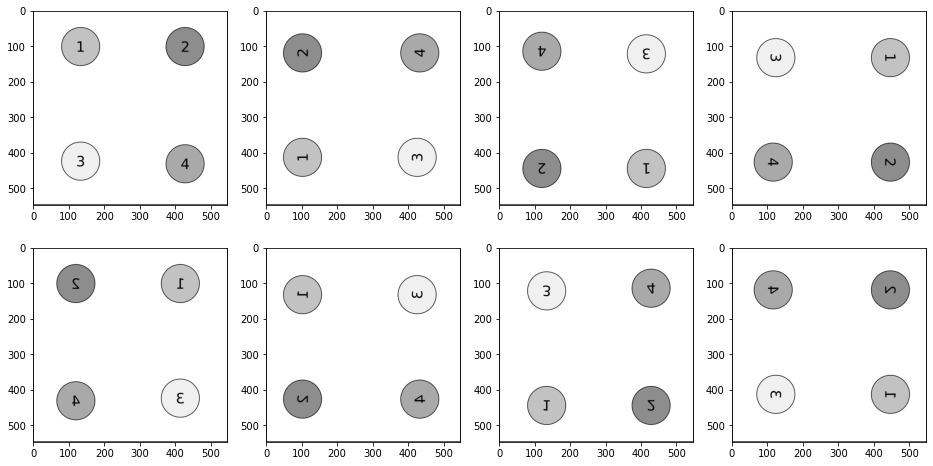

In [11]:
fig,axes = plt.subplots(2,4)
fig.set_size_inches(16,8)
for i,ax in enumerate(axes.flat):
    ax.imshow(kernels[0,i,0,...],cmap="gray")
plt.show()

#### General Convolution
In the further convolutions both the input and the filter are functions of the group. The input shape is the same as the output shape of the first convolution, while the shape of the filter is `(in channels, out channels, elements of H, spatial dim 1, spatial dim 2)`. According to the previous equation, each filter is transformed with every action of the group H and then the convolution sums over all the actions of H and all the translations. However now we need to consider that the action has effect both on the spatial dimensions and the group dimensions. To know the effect on the group dimension we need to know the result of the composition of two actions. In particular, for the Dihedral group D4 the actions - that are four rotations $r_0,r_1,r_2,r_3$ and four reflections $s_0,s_1,s_2,s_3$ - compose according to the following rules:
\begin{align*}
r_i r_j = r_{i+j \mod 4}\\
r_i s_j = s_{i+j \mod 4}\\
s_i r_j = s_{i-j \mod 4}\\
s_i s_j = r_{i-j \mod 4}
\end{align*}
At this point, the transformed filter has shape `(elements of H, in channels, out channels, elements of H, spatial dim 1, spatial dim 2)` and we can use the same trick by joining the input group elements with the input channels dimension and the output group elements with the output channels dimension, such that the planar convolution algorithm will sum over the input group elements and the output will still be a function of the elements of H.

The figure below shows how the filter transform under the actions of D4. The ith row represents the kernel weights transformed under the ith D4 action. The column id is the D4 group coordinate while the spatial coordinate are the x and y axes in the images.

In [12]:
kernel_size=128
kernel_weights = []
for i in range(8):
    img = Image.open(f"images/{i}.png").convert('L').resize((kernel_size,kernel_size))
    img_tensor = transforms.ToTensor()(img)
    kernel_weights.append(img_tensor)
kernel_weights = torch.stack(kernel_weights,dim=1)
kernel_weights = kernel_weights.unsqueeze(0)
kernel_weights.shape

torch.Size([1, 1, 8, 128, 128])

In [13]:
group_conv = GroupConvolution(group=d4,in_channels=1,out_channels=1,kernel_size=kernel_size)
group_conv.kernel.weight.data = kernel_weights#torch.einsum("abcde->acbde",kernels)#[:,[0],...].repeat(1,8,1,1,1))

In [14]:
kernels = group_conv.kernel.sample().detach()
kernels.shape

torch.Size([1, 8, 1, 8, 128, 128])

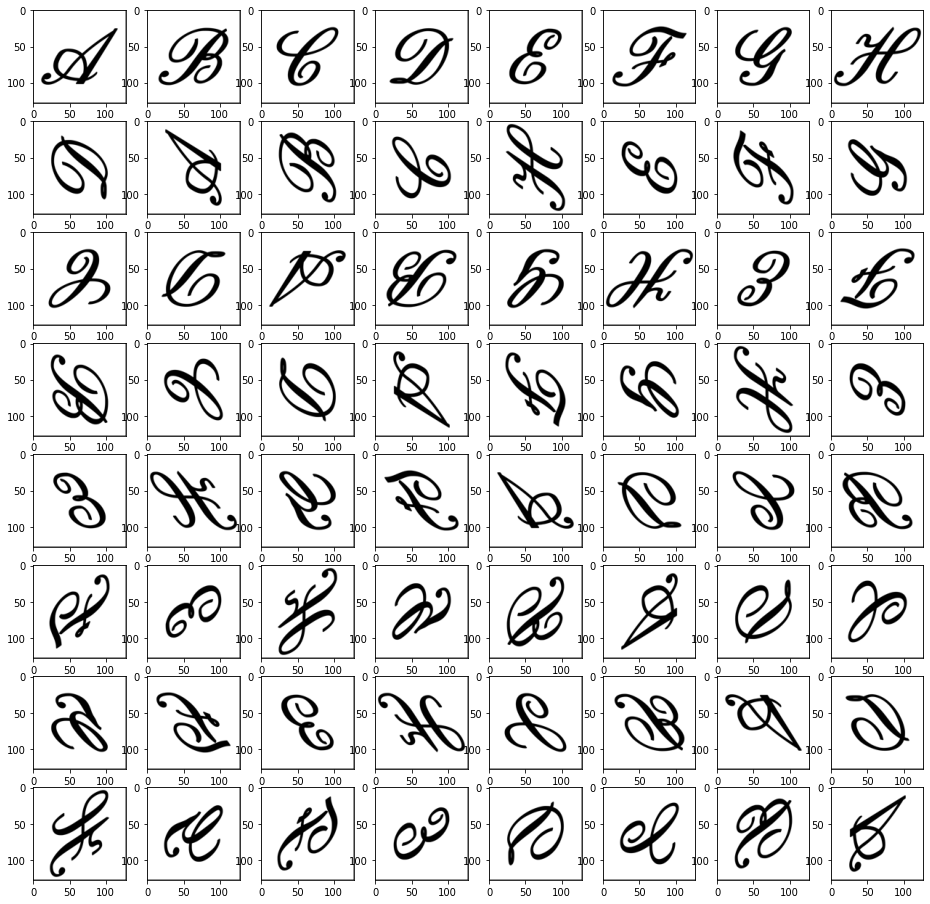

In [15]:
fig,axes = plt.subplots(8,8)
fig.set_size_inches(16,16)
for g_idx in range(8):
    for g_p_idx in range(8):
        axes[g_idx,g_p_idx].imshow(kernels[0,g_idx,0,g_p_idx,...],cmap="gray")
plt.show()

In [16]:
transformed_elems = d4.left_action_on_H(d4.elements(),d4.elements())
transformed_elems

tensor([[0., 1., 2., 3., 4., 5., 6., 7.],
        [1., 2., 3., 0., 7., 4., 5., 6.],
        [2., 3., 0., 1., 6., 7., 4., 5.],
        [3., 0., 1., 2., 5., 6., 7., 4.],
        [4., 5., 6., 7., 0., 1., 2., 3.],
        [5., 6., 7., 4., 3., 0., 1., 2.],
        [6., 7., 4., 5., 2., 3., 0., 1.],
        [7., 4., 5., 6., 1., 2., 3., 0.]])

## From Equivariance to Invariance

Up to now we implemented a convolutional layer that is equivariant to the actions of the group D4 (without loosing the translation equivariance).
In standard convolutional networks, translation invariance is obtained with strided pooling (LeCun et al., 1998), and most of the times with Max Pooling. The strided Max Pooling operation takes the maximum response over non-overlapping regions of the feature map. The resulting representation becomes invariant to local translations. 

For example, if we apply strided Max Pooling over a $2\times 2$ region, then, after n Max Pooling layers, a single pixel (with its channels) encodes the information of a $2^n \times 2^n$ patch in the original image.

If the neural network must learn a function that is invariant to translations (like for example a classification function) then we can stack Max Pooling layers until the feature map is reduced to a single pixel and there is no more spatial dimension. 

Analogously to the standard convolution, here we apply the Max Pooling to the group dimension just before the classification layer. In this way the network creates a hierarchical representation that is equivariant to the group actions until the last convolutional layer, where we get invariance from equivariance through Max Pooling.

## Results

We tested the group invariant convolutional neural network on the Fashion-MNIST dataset, which contains 28x28 grayscale images, associated with a label from 10 classes. In particular, we performed the following experiment:
- Train the Standard convolutional neural network (Standard-CNN) on Fashion-MNIST with no augmentation
- Train the C4 equivariant convolutional network (C4-NN), that is the neural network invariant to the actions of C4 (the group of 90 degrees rotations), on Fashion-MNIST with no augmentation
- Train the D4 equivariant convolutional network (D4-NN), that is the neural network invariant to the actions of D4 (the group of symmetries of a square), on Fashion-MNIST with no augmentation
- Test the three models with three testsets: 1) the testset without augmentation, 2) the testset augmented applying random actions of C4, 3) the testset augmented applying random actions of D4.

### Standard-CNN

In [17]:
# instantiate the model
N_CLASSES = 10
standard_cnn = SimpleCNN(N_CLASSES)
print(standard_cnn)

SimpleCNN(
  (c1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (r1): ReLU()
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (r2): ReLU()
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (clf): Linear(in_features=256, out_features=10, bias=True)
)


In [18]:
print(f"Number of parameters: {count_params(standard_cnn)}")

Number of parameters: 372234


In [19]:
# load the trained weights
ret = standard_cnn.load_state_dict(torch.load("ckpt/SimpleCNN_FashionMNIST.pth"))
ret

<All keys matched successfully>

#### Testing on testset without augmentation

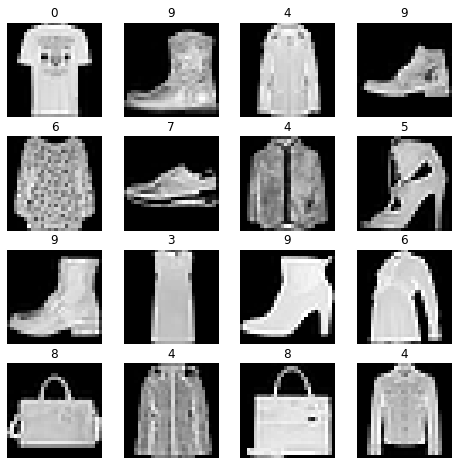

In [20]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment=None)
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [21]:
acc,loss = val(
    testset,
    standard_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:90.92%     Test Loss:0.387546


#### Testing on testset augmented with actions of C4

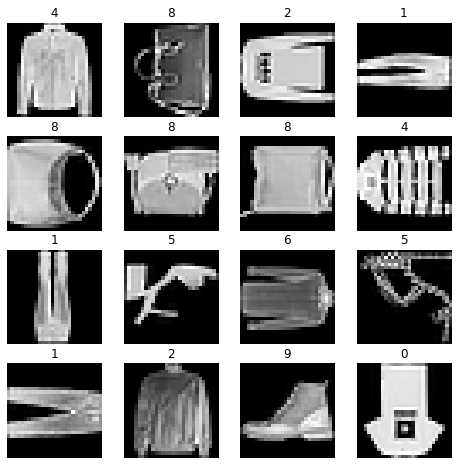

In [22]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="c4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [23]:
acc,loss = val(
    testset,
    standard_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:32.24%     Test Loss:9.471360


#### Testing on testset augmented with actions of D4

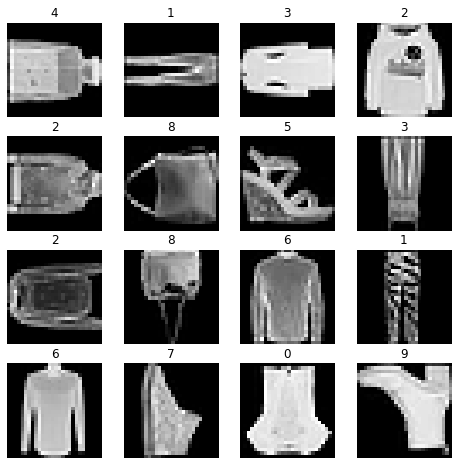

In [24]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="d4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [25]:
acc,loss = val(
    testset,
    standard_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:31.55%     Test Loss:9.369112


### C4-CNN

In [26]:
# instantiate the model
N_CLASSES = 10
c4_cnn = EqSimpleCNN(CyclicGroup(4),4,N_CLASSES)
print(c4_cnn)

EqSimpleCNN(
  (c1): LiftingConvolution(
    (kernel): InterpolativeLiftingKernel(
      (group): CyclicGroup()
    )
  )
  (r1): ReLU()
  (p1): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r2): ReLU()
  (p2): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (group_pooling): GroupMaxPool()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
print(f"Number of parameters: {count_params(c4_cnn)}")

Number of parameters: 370218


In [28]:
# load the trained weights
ret = c4_cnn.load_state_dict(torch.load("ckpt/C4SimpleCNN_FashionMNIST.pth"))
ret

<All keys matched successfully>

#### Testing on testset without augmentation

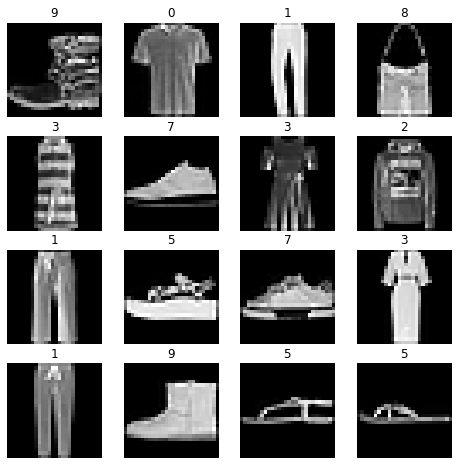

In [29]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment=None)
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [30]:
acc,loss = val(
    testset,
    c4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:89.88%     Test Loss:0.446892


#### Testing on testset augmented with actions of C4

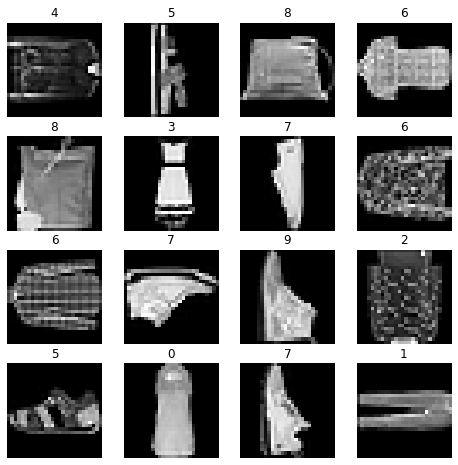

In [31]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="c4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [32]:
acc,loss = val(
    testset,
    c4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:78.56%     Test Loss:0.970423


#### Testing on testset augmented with actions of D4

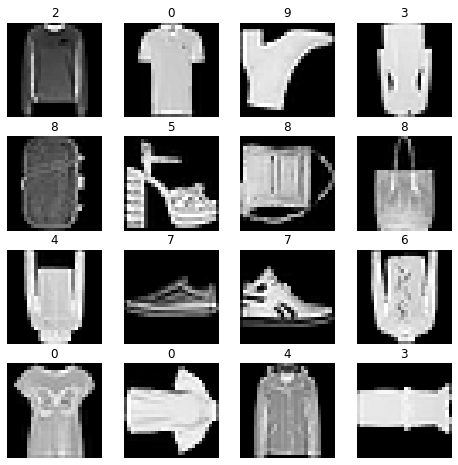

In [33]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="d4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [34]:
acc,loss = val(
    testset,
    c4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:72.31%     Test Loss:1.394827


### D4-CNN

In [35]:
# instantiate the model
N_CLASSES = 10
d4_cnn = EqSimpleCNN(DihedralGroup(4),8,N_CLASSES)
print(d4_cnn)

EqSimpleCNN(
  (c1): LiftingConvolution(
    (kernel): InterpolativeLiftingKernel(
      (group): DihedralGroup()
    )
  )
  (r1): ReLU()
  (p1): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): DihedralGroup()
    )
  )
  (r2): ReLU()
  (p2): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): DihedralGroup()
    )
  )
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (group_pooling): GroupMaxPool()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


In [36]:
print(f"Number of parameters: {count_params(d4_cnn)}")

Number of parameters: 738858


In [37]:
# load the trained weights
ret = d4_cnn.load_state_dict(torch.load("ckpt/D4SimpleCNN_FashionMNIST.pth"))
ret

<All keys matched successfully>

#### Testing on testset without augmentation

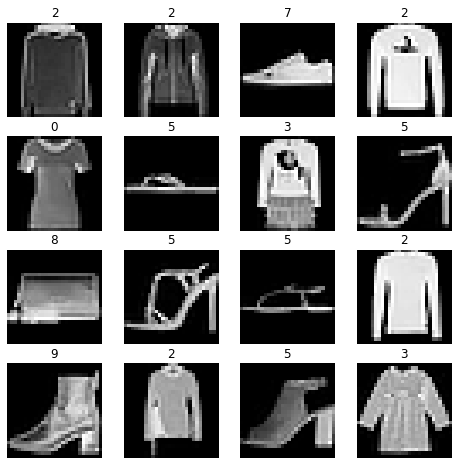

In [38]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment=None)
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [39]:
acc,loss = val(
    testset,
    d4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:89.06%     Test Loss:0.445143


#### Testing on testset augmented with actions of C4

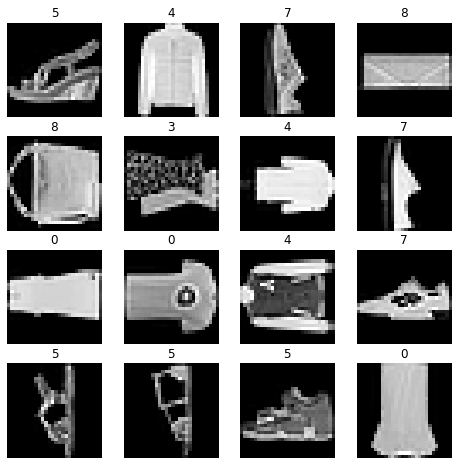

In [40]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="c4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [41]:
acc,loss = val(
    testset,
    d4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:83.82%     Test Loss:0.667559


#### Testing on testset augmented with actions of D4

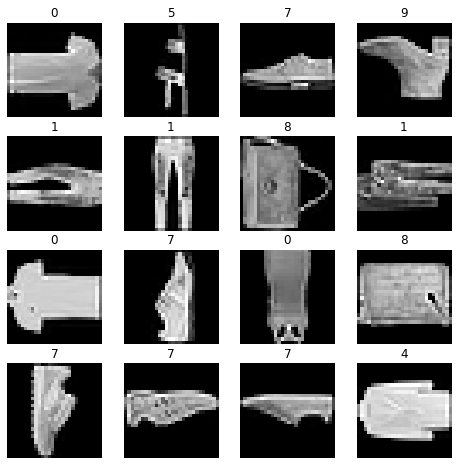

In [42]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="d4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [43]:
acc,loss = val(
    testset,
    d4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:83.45%     Test Loss:0.695109


|| Standard-CNN | C4-Invariant-CNN | D4-Invariant-CNN|
|---|---|---|---|
|No augmentation| 90.92% | 89.88%  | 89.06% |
| C4 augmentation| 32.39% | 79.12% | 84.16% |
| D4 augmentation | 31.55% | 72.21% | 83.45% |

## Conclusion
In this project we compared a standard convolutional network respectively with a D4 and C4 equivariant convolutional networks.
The results show how it is possible to get good performances on augmented dataset without using augmentation in the training (the is the most used techniques to learn invariance) but generalizing the convolution to be equivariant to a larger symmetry group with respect to translation.

## Bibliography
- Cohen, Taco, and Max Welling. "Group equivariant convolutional networks." International conference on machine learning. PMLR, 2016.
- Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016.
- GDL - Regular Group Convolutions <a href=https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Geometric_deep_learning/tutorial1_regular_group_convolutions.html>Tutorial</a>
- LeCun, Y., Bottou, L., Bengio, Y., and Haffner, P. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998
